In [11]:
%autosave 60 

Autosaving every 60 seconds


In [12]:
#default_exp segmentation.dataset

In [13]:
import fastai; print(fastai.__version__)

1.0.58.dev0


In [14]:
#export
from fastai.vision import *

### databunch

In [152]:
type('va') is str

True

In [158]:
#export 
class SemanticSegmentationData:
    "Creates semantic segmentation dataset from fastai datablock API"
    def __init__(self, PATH, IMAGES, MASKS, CODES, TRAIN, VALID, TEST,
                     sample_size, bs, size, has_test_labels=True):
        
        self.path, self.sample_size, self.bs, self.size, self.has_test_labels  =\
                                            PATH, sample_size, bs, size, has_test_labels
        self.codes, self.VALID, self.TEST = np.loadtxt(self.path/CODES, dtype=str), VALID, TEST
        
        self.train_df = pd.read_csv(self.path/TRAIN, header=None)
        
        if (VALID is not None) and (type(VALID) is str): self.valid_file = True
        else: self.valid_file = False
            
        if self.valid_file: self.valid_df = pd.read_csv(self.path/VALID, header=None)
        
        if TEST is not None: self.test_df = pd.read_csv(self.path/TEST, header=None)
        
        self.path_img, self.path_lbl = self.path/IMAGES, self.path/MASKS
        
    def get_y_fn(self, x): return self.path_lbl/f'{Path(x).stem}.png'
        
    def get_data(self):        
        if self.valid_file: 
            self.train_valid_df = pd.concat([self.train_df, self.valid_df])
            self.train_valid_df.columns = ["images"]
            self.train_valid_df["is_valid"] = len(self.train_df)*[False] + len(self.valid_df)*[True]
        else:
            self.train_valid_df = self.train_df
        
        il = SegmentationItemList.from_df(self.train_valid_df, self.path, folder="images") # get
        if self.valid_file: ill = il.split_from_df("is_valid") # split
        else: ill = il.split_by_rand_pct(ifnone(self.VALID, 0.2)) # split
        ll = ill.label_from_func(self.get_y_fn, classes=self.codes) # label
            
        data = (ll.transform(get_transforms(), size=(self.size, self.size), tfm_y=True,
                             resize_method=ResizeMethod.SQUISH)
                    .databunch(bs=self.bs))
        # add_test
        if self.TEST:
            il = SegmentationItemList.from_df(self.test_df, self.path, folder="images") # get
            data.add_test(il, tfm_y=False)
        return data
        
    def __repr__(self):
        return f"""___repr__"""
    
    def __str__(self):
        return f"""___str___"""

In [153]:
ifnone??

### Download CAMVID to `.fastai/data` and reformat for `SemanticSegmentationData`

In [21]:
# fastai.datasets.download_data(URLs.CAMVID)

In [27]:
PATH = Path("/home/turgutluk/.fastai/data/camvid")
IMAGES = "images"
MASKS = "labels"

In [28]:
PATH.ls()

[PosixPath('/home/turgutluk/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/turgutluk/.fastai/data/camvid/images'),
 PosixPath('/home/turgutluk/.fastai/data/camvid/labels'),
 PosixPath('/home/turgutluk/.fastai/data/camvid/valid.txt')]

In [94]:
CODES = "codes.txt"

In [124]:
imagefiles = get_files(PATH/IMAGES)
maskfiles = get_files(PATH/MASKS)

In [126]:
imagefiles[:2]

[PosixPath('/home/turgutluk/.fastai/data/camvid/images/0016E5_08079.png'),
 PosixPath('/home/turgutluk/.fastai/data/camvid/images/Seq05VD_f02700.png')]

In [127]:
maskfiles[:2]

[PosixPath('/home/turgutluk/.fastai/data/camvid/labels/0016E5_08079.png'),
 PosixPath('/home/turgutluk/.fastai/data/camvid/labels/Seq05VD_f05070_P.png')]

In [86]:
def _fix_camvid_maskfn(o:PathOrStr, i:int):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(o).convert("L")
        new_fn = o.parent/f"{o.stem[:-2]}.png"
        x.save(new_fn)
    return new_fn

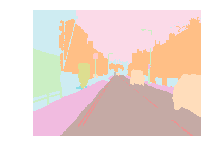

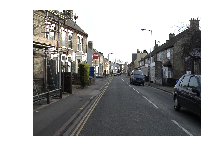

In [87]:
# test conversion
try:
    o = maskfiles[0]
    fn = _fix_camvid_maskfn(o, 0)
    open_mask(fn).show()
    open_image(PATH/IMAGES/f"{fn.stem}.png").show()
except: 
    raise AssertionError

In [89]:
new_maskfiles = parallel(_fix_camvid_maskfn, maskfiles, max_workers=36)

In [128]:
validfn = open(PATH/"valid.txt").read().strip().split("\n")

In [132]:
testfn = open(PATH/"test.txt").read().strip().split("\n")

In [129]:
validfn[:2]

['0016E5_07959.png', '0016E5_07961.png']

In [130]:
trainfn = [o.name for o in imagefiles if o.name not in validfn]

In [135]:
testfn = validfn

In [136]:
len(validfn), len(trainfn), len(testfn)

(101, 600, 101)

In [141]:
with open(PATH/"train.txt", "w") as f: f.write("\n".join(trainfn))
with open(PATH/"test.txt", "w") as f: f.write("\n".join(validfn))

### `get_data`

In [159]:
# test data creation
TRAIN, VALID, TEST = "train.txt", "valid.txt", "test.txt"
ssdata = SemanticSegmentationData(PATH, IMAGES, MASKS, CODES, TRAIN, VALID, TEST, sample_size=None, bs=4, size=112)
data = ssdata.get_data(); data

ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: SegmentationLabelList
ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112)
Path: /home/turgutluk/.fastai/data/camvid;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: SegmentationLabelList
ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112)
Path: /home/turgutluk/.fastai/data/camvid;

Test: LabelList (101 items)
x: SegmentationItemList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: EmptyLabelList
,,,,
Path: /home/turgutluk/.fastai/data/camvid

### random default validation  (0.2)

In [160]:
# random validation
ssdata = SemanticSegmentationData(PATH, IMAGES, MASKS, CODES, TRAIN, None, TEST, sample_size=None, bs=4, size=112)
data = ssdata.get_data(); data

ImageDataBunch;

Train: LabelList (480 items)
x: SegmentationItemList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: SegmentationLabelList
ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112)
Path: /home/turgutluk/.fastai/data/camvid;

Valid: LabelList (120 items)
x: SegmentationItemList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: SegmentationLabelList
ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112)
Path: /home/turgutluk/.fastai/data/camvid;

Test: LabelList (101 items)
x: SegmentationItemList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: EmptyLabelList
,,,,
Path: /home/turgutluk/.fastai/data/camvid

### random validation by pct

In [160]:
# random validation
ssdata = SemanticSegmentationData(PATH, IMAGES, MASKS, CODES, TRAIN, None, TEST, sample_size=None, bs=4, size=112)
data = ssdata.get_data(); data

ImageDataBunch;

Train: LabelList (480 items)
x: SegmentationItemList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: SegmentationLabelList
ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112)
Path: /home/turgutluk/.fastai/data/camvid;

Valid: LabelList (120 items)
x: SegmentationItemList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: SegmentationLabelList
ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112)
Path: /home/turgutluk/.fastai/data/camvid;

Test: LabelList (101 items)
x: SegmentationItemList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: EmptyLabelList
,,,,
Path: /home/turgutluk/.fastai/data/camvid

### binary: SIIM

In [59]:
# custom validation
PATH, CODES, TRAIN, VALID, TEST = Path(USERSPACE/'siim'), "codes.txt", "train.txt", None, "test.txt"
ssdata = SemanticSegmentationData(PATH, CODES, TRAIN, VALID, TEST, sample_size=None, bs=4, size=112, has_test_labels=False)
data = ssdata.get_data()

In [60]:
data

ImageDataBunch;

Train: LabelList (9638 items)
x: SegmentationItemList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: SegmentationLabelList
ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112)
Path: /trainman-mount/trainman-storage-ac168968-e641-4146-85da-cf960ab9e0bc/siim;

Valid: LabelList (2409 items)
x: SegmentationItemList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: SegmentationLabelList
ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112),ImageSegment (1, 112, 112)
Path: /trainman-mount/trainman-storage-ac168968-e641-4146-85da-cf960ab9e0bc/siim;

Test: LabelList (3205 items)
x: SegmentationItemList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: EmptyLabelList
,,,,
Path: /trainm

In [104]:
data.c

2

### Fix SIIM masks

In [198]:
# mask_files = get_files(PATH/"masks")

In [218]:
# for fname in mask_files:
#     mask = open_mask(fname)
#     pixel_vals = mask.data.unique()
#     if len(pixel_vals) == 1: assert pixel_vals.item() == 0
#     elif len(pixel_vals) == 2: assert torch.equal(pixel_vals, tensor([1,0]))
#     else: 
#         mask = open_mask(fname, div=True)
#         pixel_vals = mask.data.unique()
#         assert torch.equal(pixel_vals, tensor([1,0]))
#         PIL.Image.fromarray(image2np(mask.data).astype(np.uint8)).save(PATH/"masks"/f"{fname}.png")

In [219]:
# for fname in mask_files:
#     mask = open_mask(fname)
#     pixel_vals = mask.data.unique()
#     if len(pixel_vals) == 1: assert pixel_vals.item() == 0
#     elif len(pixel_vals) == 2: assert torch.equal(pixel_vals, tensor([1,0]))
#     else: assert False